In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os
import glob as glob
from pathlib import Path
from datetime import datetime

from pyannote.audio import Pipeline
from pyannote.core import json
from pyannote.core.timeline import Timeline

import moviepy.editor as mp

from matplotlib import pyplot as plt, lines
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src import (
    downsample as downsamp_audio, 
    embedding_extractor as ee, 
    dimension_reducer as dr, 
    distance_metrics as dm, 
    downsample as ds,
    emb_manipulator as em
)

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
##Downsample audio to 16kHz
root_dir= "/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants"
!ls $root_dir/video

BB005_BookReading.mp4 BB013_BookReading.mp4 BB020_BookReading.mp4
BB006_BookReading.mp4 BB014_BookReading.mp4 BB021_BookReading.mp4
BB008_BookReading.mp4 BB016_BookReading.mov BB022_BookReading.mov
BB012_BookReading.mov BB019_BookReading.mp4 BB038_BookReading.mp4


In [14]:
# extract audio from video files
vid_files = glob.glob(root_dir + '/video/*', recursive=True)
{Path(vid).stem.split("_")[0]:
           vid for vid in vid_files}

my_clip = {Path(vid).stem.split("_")[0]:
           mp.VideoFileClip(vid) for vid in vid_files}

aud_files = os.path.join(root_dir,'audio')
  
if not os.path.exists(aud_files):
    os.mkdir(aud_files)
    
[mov.audio.write_audiofile(os.path.join(aud_files,part + '.wav')) for part,mov in my_clip.items()]

MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB006.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB016.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB022.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB019.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB008.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB012.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB014.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB005.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB038.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB021.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB013.wav


MoviePy - Done.
MoviePy - Writing audio in /Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio/BB020.wav


MoviePy - Done.


[None, None, None, None, None, None, None, None, None, None, None, None]

In [15]:
#make a folder with today's date for the downsampled audio
down_sample_dir = os.path.join(root_dir,"audio_16kz")

if not os.path.exists(down_sample_dir):
    os.mkdir(down_sample_dir)

down_sample_dir

'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz'

In [16]:
ds.downsamp_audio(aud_files, down_sample_dir)

processingBB013.wav


In [30]:
##Diarize audio to find when mother is speaking and visualize it to choose label

diar_dir = os.path.join(root_dir,'diarized')
  
if not os.path.exists(diar_dir):
    os.mkdir(diar_dir)

diar_dir

'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/diarized'

In [19]:
## Runs speaker diariztion, but should run on openmind

#pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2022.07")

#for file in os.listdir(down_sample_dir):
#    if file.endswith('wav'):
#        diar = pipeline(os.path.join(down_sample_dir,file))
#        json.dump_to(diar, os.path.join(diar_dir, os.path.splitext(file)[0]+'.json'))

In [31]:
diarized_raw = {os.path.splitext(file)[0]:
            json.load_from(os.path.join(diar_dir,file)) for file in os.listdir(diar_dir)}

In [32]:
diarized_raw.keys()

dict_keys(['BB019', 'BB038', 'BB014', 'BB022', 'BB013', 'BB005', 'BB008', 'BB012', 'BB006', 'BB021', 'BB016', 'BB020'])

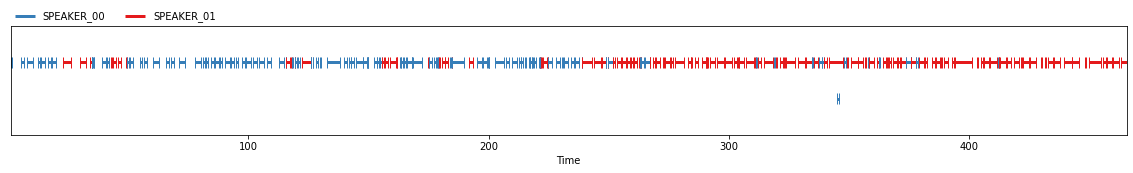

In [135]:
diarized_raw['BB020']

In [116]:
# Based on output of diarization, manually make speaker map to set which speaker we want

#BB014 speaker 00 seems to be baby fussing
speaker_map = {'BB019':['SPEAKER_00','SPEAKER_01','SPEAKER_02'], 
               'BB038':['SPEAKER_00','SPEAKER_01'],
               'BB014':['SPEAKER_01'],
               'BB022':['SPEAKER_00'],
               'BB013':['SPEAKER_00'],
               'BB005':['SPEAKER_00','SPEAKER_01'],
               'BB008':['SPEAKER_00','SPEAKER_01'],
               'BB012':['SPEAKER_00','SPEAKER_01','SPEAKER_02'],
               'BB006':['SPEAKER_00','SPEAKER_01', 'SPEAKER_02', 
                        'SPEAKER_03', 'SPEAKER_04', 'SPEAKER_05', 
                        'SPEAKER_06', 'SPEAKER_07', 'SPEAKER_08', 'SPEAKER_09'],
               'BB021':['SPEAKER_00','SPEAKER_01'],
               'BB016':['SPEAKER_00', 'SPEAKER_01', 'SPEAKER_02', 'SPEAKER_03', 'SPEAKER_04'],
               'BB020':['SPEAKER_00','SPEAKER_01'],
              }

temp = {label:[diarized_raw[label].label_timeline(s) for s in s_list]
        for label,s_list in speaker_map.items() 
       }

diarized = {}

for label, all_timelines in temp.items():
    all_seg = Timeline()
    for timeline in all_timelines:
        all_seg = all_seg.union(timeline)
    diarized[label] = all_seg

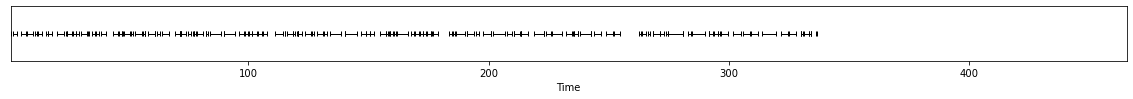

In [121]:
diarized['BB006']

In [136]:


diarized2 = {os.path.splitext(file)[0]:
            json.load_from(os.path.join(diar_dir,file)).label_timeline(
                speaker_map[os.path.splitext(file)[0]]) 
            for file in os.listdir(diar_dir)}

In [137]:
diarized2

{'BB019': <Timeline(uri=BB019, segments=[])>,
 'BB038': <Timeline(uri=BB038, segments=[])>,
 'BB014': <Timeline(uri=BB014, segments=[])>,
 'BB022': <Timeline(uri=BB022, segments=[])>,
 'BB013': <Timeline(uri=BB013, segments=[])>,
 'BB005': <Timeline(uri=BB005, segments=[])>,
 'BB008': <Timeline(uri=BB008, segments=[])>,
 'BB012': <Timeline(uri=BB012, segments=[])>,
 'BB006': <Timeline(uri=BB006, segments=[])>,
 'BB021': <Timeline(uri=BB021, segments=[])>,
 'BB016': <Timeline(uri=BB016, segments=[])>,
 'BB020': <Timeline(uri=BB020, segments=[])>}

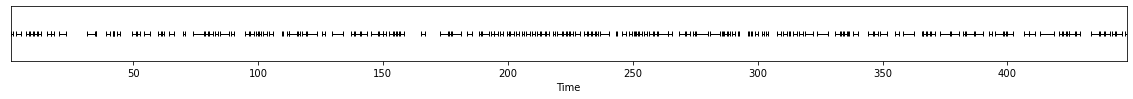

In [16]:
diarized['BB042']

In [139]:
emb_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
save_name = datetime.now().strftime('%Y_%m_%d') + '_12BBs.csv'
diarized = diarized

import glob
#all_files = glob.glob(down_sample_dir+'/*/*', recursive=True)
#all_files = [file for file in all_files if 'script' in file]

all_files = glob.glob(down_sample_dir+'/*', recursive=True)

save_name, all_files

('2022_08_03_12BBs.csv',
 ['/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB022.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB021.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB008.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB020.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB019.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB016.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB014.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB005.wav',
  '/Users/rahulbrito/Documents/

In [140]:
pyannote_emb = ee.pyannote_extract_directory(all_files, diarized,emb_dir,save_name,window_type="sliding",save=True)
pyannote_emb

Processing/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/080222_new_participants/audio_16kz/BB013.wav
Done


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,part_id
0,-4.406202,-67.485840,-37.829342,-9.128765,-51.804512,58.935211,-8.892576,-15.760887,10.177029,5.072660,...,-60.274281,-0.820661,-0.406244,24.124588,-35.420895,4.064081,-17.303673,41.797432,-42.089180,BB022
1,-40.024433,-95.250328,-42.192551,-24.084930,-77.079323,-12.025150,-15.501102,23.396961,-16.820007,-10.302286,...,-87.619957,-13.567125,-23.401587,-8.024067,-40.295525,-13.316298,-59.617043,3.470016,-73.789963,BB022
2,4.597473,-31.503448,24.261417,-33.212387,-36.229469,18.378212,-62.295547,-14.799171,-23.762167,-50.631851,...,-42.960854,79.430382,-60.812157,25.384315,36.669449,-14.570815,-74.762756,10.190239,3.853316,BB022
3,-69.537056,-88.167351,-38.912643,-28.553596,-44.487045,-36.716045,43.535599,21.043612,-2.945155,-81.075974,...,21.426743,30.822914,-56.134010,29.063692,-13.498871,58.351696,-44.677361,-19.122536,-17.766455,BB022
4,-58.300331,-56.928734,48.829948,57.407642,-25.018295,-30.948965,-46.420174,19.716545,-60.264938,-6.729778,...,-13.241426,34.583488,-50.702774,13.746834,-60.041885,36.220501,21.908291,-19.559460,-75.602676,BB022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,33.538929,-44.438747,-106.491867,-65.378723,29.767151,-43.519287,-13.560040,-9.681160,-38.563156,-3.602527,...,5.524525,34.089661,-7.352064,-18.993959,40.320835,57.431541,-17.455727,-13.301113,-20.623173,BB013
278,-18.915598,-49.348045,0.297806,2.940094,19.733189,-26.900269,10.687899,6.943342,4.721202,-3.530552,...,18.563042,-12.648318,-37.101151,-38.048378,-33.145611,-13.577005,-41.743767,-9.341431,69.514740,BB013
279,37.701382,-66.167702,3.902802,-89.714523,10.062946,55.052208,-29.008738,-35.160221,-5.282740,6.912895,...,47.874828,40.317169,-12.658104,-11.279747,-10.275951,20.313587,-87.196091,-20.242706,27.078608,BB013
280,-43.012554,-40.573753,-6.492107,-28.335197,14.953876,-10.177116,-27.849380,23.035198,7.829312,-55.054291,...,-52.515553,-22.686626,-60.317127,22.572422,19.650291,6.637623,-127.648521,-124.431931,2.610559,BB013


In [141]:
len(all_files)

12

In [142]:
emb = pd.read_csv(os.path.join(emb_dir,save_name), index_col=0)
emb.shape

(282, 513)

In [145]:
emb.part_id

0      BB022
1      BB022
2      BB022
3      BB022
4      BB022
       ...  
277    BB013
278    BB013
279    BB013
280    BB013
281    BB013
Name: part_id, Length: 282, dtype: object

In [146]:
emb

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,part_id
0,-4.406202,-67.485840,-37.829342,-9.128765,-51.804512,58.935211,-8.892576,-15.760887,10.177029,5.072660,...,-60.274281,-0.820661,-0.406244,24.124588,-35.420895,4.064081,-17.303673,41.797432,-42.089180,BB022
1,-40.024433,-95.250328,-42.192551,-24.084930,-77.079323,-12.025150,-15.501102,23.396961,-16.820007,-10.302286,...,-87.619957,-13.567125,-23.401587,-8.024067,-40.295525,-13.316298,-59.617043,3.470016,-73.789963,BB022
2,4.597473,-31.503448,24.261417,-33.212387,-36.229469,18.378212,-62.295547,-14.799171,-23.762167,-50.631851,...,-42.960854,79.430382,-60.812157,25.384315,36.669449,-14.570815,-74.762756,10.190239,3.853316,BB022
3,-69.537056,-88.167351,-38.912643,-28.553596,-44.487045,-36.716045,43.535599,21.043612,-2.945155,-81.075974,...,21.426743,30.822914,-56.134010,29.063692,-13.498871,58.351696,-44.677361,-19.122536,-17.766455,BB022
4,-58.300331,-56.928734,48.829948,57.407642,-25.018295,-30.948965,-46.420174,19.716545,-60.264938,-6.729778,...,-13.241426,34.583488,-50.702774,13.746834,-60.041885,36.220501,21.908291,-19.559460,-75.602676,BB022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,33.538929,-44.438747,-106.491867,-65.378723,29.767151,-43.519287,-13.560040,-9.681160,-38.563156,-3.602527,...,5.524525,34.089661,-7.352064,-18.993959,40.320835,57.431541,-17.455727,-13.301113,-20.623173,BB013
278,-18.915598,-49.348045,0.297806,2.940094,19.733189,-26.900269,10.687899,6.943342,4.721202,-3.530552,...,18.563042,-12.648318,-37.101151,-38.048378,-33.145611,-13.577005,-41.743767,-9.341431,69.514740,BB013
279,37.701382,-66.167702,3.902802,-89.714523,10.062946,55.052208,-29.008738,-35.160221,-5.282740,6.912895,...,47.874828,40.317169,-12.658104,-11.279747,-10.275951,20.313587,-87.196091,-20.242706,27.078608,BB013
280,-43.012554,-40.573753,-6.492107,-28.335197,14.953876,-10.177116,-27.849380,23.035198,7.829312,-55.054291,...,-52.515553,-22.686626,-60.317127,22.572422,19.650291,6.637623,-127.648521,-124.431931,2.610559,BB013
